# Import libraries

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import string
import re
from nltk.corpus import stopwords
import seaborn as sns
import statsmodels.api as sm
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report, balanced_accuracy_score, roc_auc_score, roc_curve, auc, recall_score, precision_score
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from scipy.stats import randint
import xgboost as xgb

In [4]:
df_output = pd.read_csv("data/output.csv")
df_politics = pd.read_csv("data/cleaned_data.csv")

Merge the politeness

In [5]:
df_politeness = pd.read_csv("data/politeness_features.csv")

In [6]:
df_politics = df_politics.merge(df_politeness)

In [7]:
df_politics

,Unnamed: 0,username,post,political_leaning,cleaned_post,amount_of_cursewords,Hedges,Impersonal.Pronoun,Swearing,Negation,...,Second.Person,Third.Person,Positive.Emotion,Negative.Emotion,Questions,Gratitude,Apology,Truth.Intensifier,Affirmation,Conjunction.Start
0,1,t2_7ramzeng,"me want to play Q*bert Holy shit, based Alex J...",right,want play qbert holy shit based alex jones bro...,2,9,109,2,33,...,18,32,73,42,15,4,2,4,0,0
1,2,t2_7ramzeng,Shouldn't rely on any external services or per...,right,shouldnt rely external service persistent data...,3,27,99,2,34,...,34,44,60,35,4,0,1,9,0,0
2,3,t2_7ramzeng,PR to a specific person. Usually that just mea...,right,pr specific person usually mean roundrobin app...,5,18,104,2,30,...,34,47,49,48,9,0,0,1,0,0
3,4,t2_7ramzeng,This article's intention is clear that they wa...,right,article intention clear want imply causal rela...,1,29,101,2,29,...,33,42,45,34,6,0,0,0,0,0
4,5,t2_7ramzeng,is big and a safe investment (by pretending th...,right,big safe investment pretending market includes...,7,20,90,4,30,...,22,51,44,29,9,0,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57225,57226,t2_4ngvl16j,a good one? That's odd. I remember it as being...,center,good one thats odd remember may closer may clo...,5,11,114,7,62,...,46,25,42,87,11,4,1,7,0,0
57226,57227,t2_4ngvl16j,"boring shit in the fucking world. ""History doe...",center,boring shit fucking world history doesnt repea...,11,16,87,6,72,...,60,32,72,58,24,4,3,4,0,0
57227,57228,t2_4ngvl16j,you see no contradiction there? Why or why not...,center,see contradiction gtor seriously brain damaged...,14,17,115,7,66,...,64,13,52,79,26,2,1,7,0,0
57228,57229,t2_4ngvl16j,is only created by an incommensurate worldview...,center,created incommensurate worldview im sure castr...,14,14,129,8,63,...,64,18,65,55,13,3,0,1,0,0


# Representation check


In [8]:
baseline = (df_politics['political_leaning'].value_counts() / len(df_politics)) * 100
print(baseline)


political_leaning
center    44.034597
right     30.496243
left      25.469160
Name: count, dtype: float64


# Applying standard linear regression

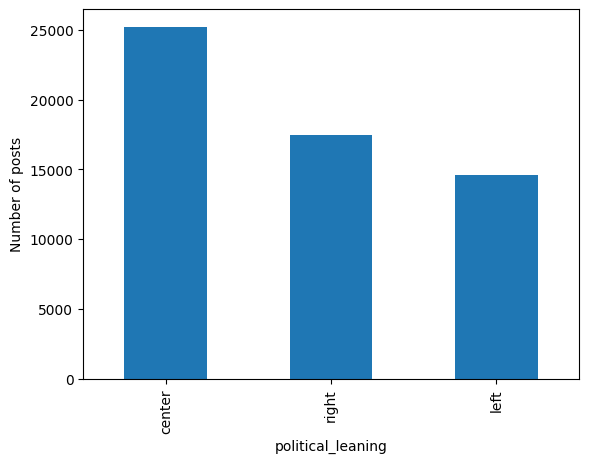

In [9]:
df_politics.value_counts('political_leaning').plot(kind='bar', fontsize=10, xlabel = "political_leaning", ylabel="Number of posts");

In [10]:
# create a new column called political_leaning_id which maps political_leaning to a numerical value with -1 being left, 0 being center, and 1 being right
# this is done because the model cannot take in string values
df_politics['political_leaning_id'] = df_politics['political_leaning'].map({'left': 0, 'center': 1, 'right': 2})

In [11]:
correlation = df_politics['political_leaning_id'].corr(df_politics['amount_of_cursewords'])
df_new = df_politics[['political_leaning_id', 'amount_of_cursewords']].copy()
correlation_matrix = df_new.corr()
print(correlation_matrix)

                      political_leaning_id  amount_of_cursewords
political_leaning_id              1.000000              0.053981
amount_of_cursewords              0.053981              1.000000


In [12]:
X = df_politics.drop(['Unnamed: 0', 'username', 'post', 'political_leaning', 'cleaned_post', 'political_leaning_id'], axis=1)
Y = df_politics['political_leaning_id']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# add constant
X_train = sm.add_constant(X_train)

# performing the regression and fitting the model
results = sm.OLS(y_train, X_train).fit()

print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     political_leaning_id   R-squared:                       0.030
Model:                              OLS   Adj. R-squared:                  0.029
Method:                   Least Squares   F-statistic:                     41.10
Date:                  Fri, 12 Jan 2024   Prob (F-statistic):          1.23e-267
Time:                          14:22:04   Log-Likelihood:                -50848.
No. Observations:                 45784   AIC:                         1.018e+05
Df Residuals:                     45749   BIC:                         1.021e+05
Df Model:                            34                                         
Covariance Type:              nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const       

In [13]:
significant = ['amount_of_cursewords', 'Hedges', 'Impersonal.Pronoun', 'Swearing', 'Negation', 'Filler.Pause', 'Informal.Title', 'Goodbye', 'For.Me', 'Reasoning', 'Reassurance', 'Ask.Agency', 'Give.Agency', 'First.Person.Plural', 'First.Person.Single', 'Second.Person', 'Third.Person', 'Positive.Emotion', 'Negative.Emotion', 'Questions', 'Apology', 'Truth.Intensifier', 'Conjunction.Start']
super_significant = ['amount_of_cursewords', 'Hedges', 'Impersonal.Pronoun', 'Swearing', 'Negation', 'Filler.Pause', 'Informal.Title', 'Reasoning', 'First.Person.Plural', 'First.Person.Single', 'Second.Person', 'Questions', 'Apology', 'Truth.Intensifier']

## Taking a closer look at the data

In [14]:
# calculate where std 1-3 of the data is below
threesigma = df_politics['amount_of_cursewords'].quantile(0.997)
twosigma = df_politics['amount_of_cursewords'].quantile(0.95)
onesigma = df_politics['amount_of_cursewords'].quantile(0.68)
print(threesigma, twosigma, onesigma)

52.0 21.0 10.0


In [15]:
df_politics[df_politics['amount_of_cursewords'] >= 52]

,Unnamed: 0,username,post,political_leaning,cleaned_post,amount_of_cursewords,Hedges,Impersonal.Pronoun,Swearing,Negation,...,Third.Person,Positive.Emotion,Negative.Emotion,Questions,Gratitude,Apology,Truth.Intensifier,Affirmation,Conjunction.Start,political_leaning_id
292,293,t2_yhe63e4,and Heydrich et al. 2: Its spelled Eichmann As...,center,heydrich et al spelled eichmann someone consid...,201,7,47,11,24,...,18,41,44,17,0,0,2,0,0,1
2337,2338,t2_6308kyoq,"pretty down right now, im dad u/repostsleuthbo...",center,pretty right im dad urepostsleuthbot yeah id l...,1252,8,69,9,34,...,14,68,51,28,7,5,7,0,0,1
2338,2339,t2_6308kyoq,cum cum cum cum cum cum cum cum cum cum cum cu...,center,cum cum cum cum cum cum cum cum cum cum cum cu...,769,1,17,0,6,...,7,14,13,0,0,0,1,0,0,1
7125,7126,t2_5wck8ax5,a toe tag. Oh yeah Amazing Amazing Wow Thanks ...,center,toe tag oh yeah amazing amazing wow thanks wow...,67,15,101,23,32,...,34,72,76,15,6,3,5,0,0,1
10006,10007,t2_udczs,the chance of it working is really low lol. Th...,right,chance working really low lol guy basically st...,52,25,78,11,46,...,37,79,75,11,0,0,11,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47053,47054,t2_4oy6tqzq,he his helped senegal win U da goat Wtf ronny ...,center,helped senegal win u da goat wtf ronny watchin...,52,10,94,34,23,...,38,55,84,15,0,0,7,0,0,1
49369,49370,t2_70nq1e7t,(: Can i crush your balls 🥰😍😍😍🥵🥵🥵🥵🤤🤤🤤🤤🤤 Minecu...,right,crush ball minecum ruselessredcircle youre mom...,1195,9,89,34,32,...,33,61,79,18,1,0,4,0,0,2
49370,49371,t2_70nq1e7t,cum cum cum cum cum cum cum cum cum cum cum cu...,right,cum cum cum cum cum cum cum cum cum cum cum cu...,615,5,14,12,5,...,2,4,22,3,0,1,1,0,0,2
55326,55327,t2_14xq38,loses reproductive rights Irish joe at it agai...,left,loses reproductive right irish joe also checke...,55,15,78,22,40,...,91,55,67,15,0,0,3,0,0,0


In [16]:
df_politics_cleaned = df_politics[df_politics['amount_of_cursewords'] <= 52]

In [17]:
# #Wordcloud en mooie plaatje:

# df_right = df_politics_cleaned[df_politics_cleaned['political_leaning'] == 'right']
# df_left = df_politics_cleaned[df_politics_cleaned['political_leaning'] == 'left']
# df_centered = df_politics_cleaned[df_politics_cleaned['political_leaning'] == 'center']
# right_text = " ".join(word for word in df_right.post)
# print("There are {} words in the combination of all review.".format(len(right_text)))
# left_text = " ".join(word for word in df_left.post)
# print("There are {} words in the combination of all review.".format(len(left_text)))
# centered_text = " ".join(word for word in df_centered.post)
# print("There are {} words in the combination of all review.".format(len(centered_text)))
# # Create and generate a word cloud image:
# wordcloud = WordCloud().generate(right_text)

# # Display the generated image:
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.show()

In [18]:
# wordcloud = WordCloud().generate(left_text)

# # Display the generated image:
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.show()

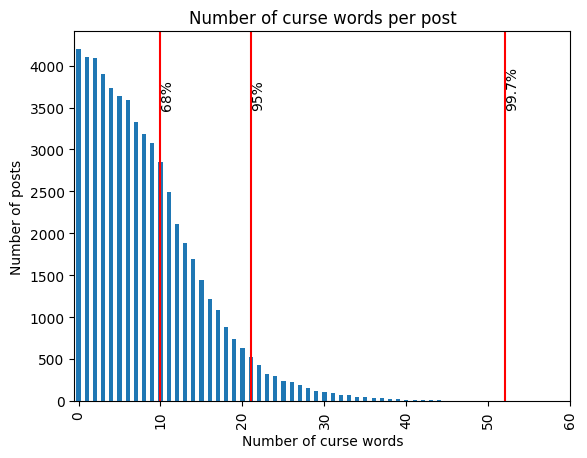

In [19]:
df_politics_cleaned.value_counts('amount_of_cursewords').plot(kind='bar', fontsize=10, xlabel = "Number of curse words", ylabel="Number of posts", title="Number of curse words per post", xticks=np.arange(0, 61, 10))

#plot the 1, 2, and 3 sigma lines
plt.axvline(x=onesigma, color='r', linestyle='-')
plt.axvline(x=twosigma, color='r', linestyle='-')
plt.axvline(x=threesigma, color='r', linestyle='-')

# annotate the 1, 2, and 3 sigma lines
plt.text(onesigma, 3500, '68%', rotation=90)
plt.text(twosigma, 3500, '95%', rotation=90)
plt.text(threesigma, 3500, '99.7%', rotation=90);

amount_of_cursewords 52.0 174


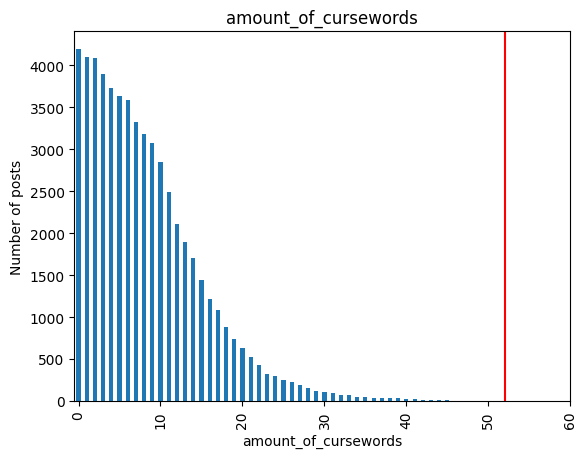

Hedges 35.0 228


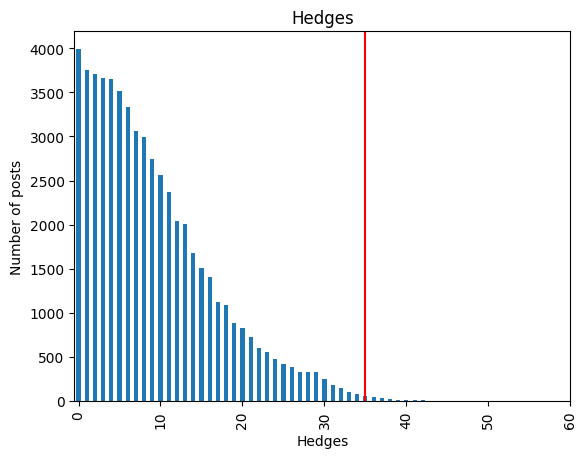

Impersonal.Pronoun 147.0 201


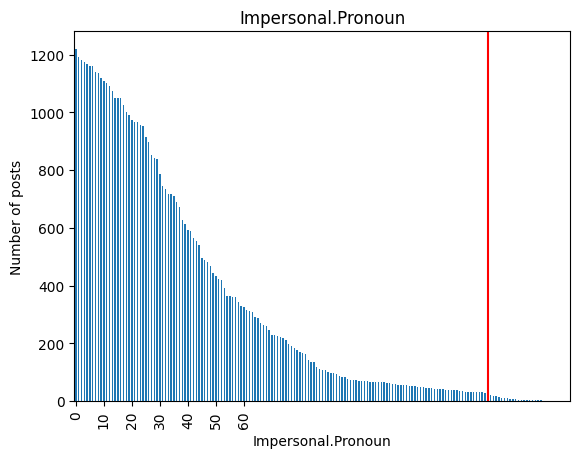

Swearing 31.0 202


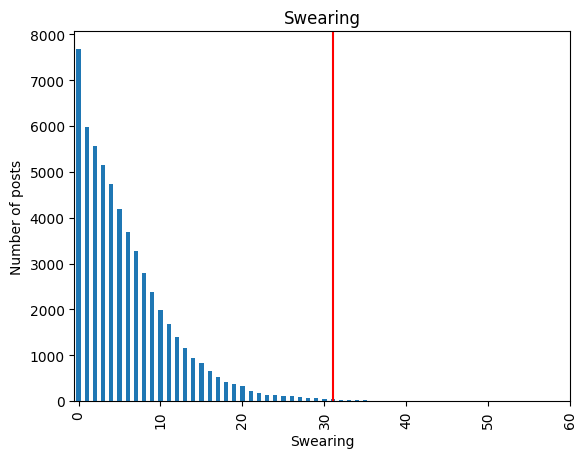

Negation 73.0 192


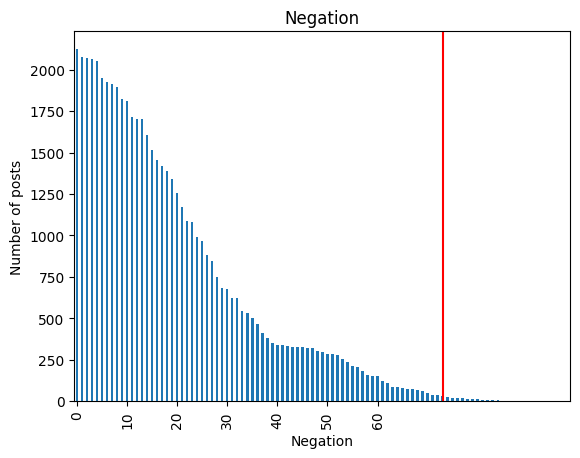

Filler.Pause 38.0 176


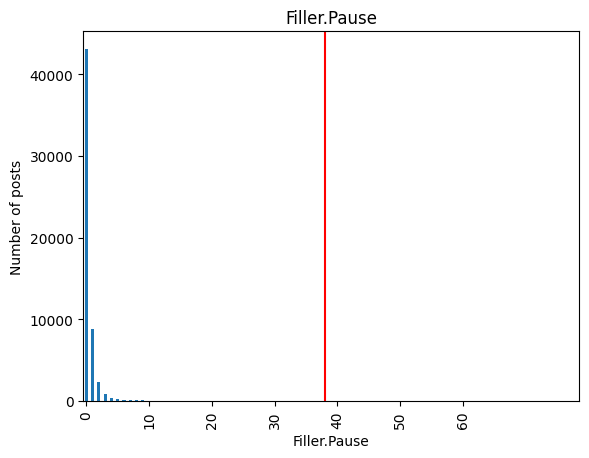

Informal.Title 19.0 211


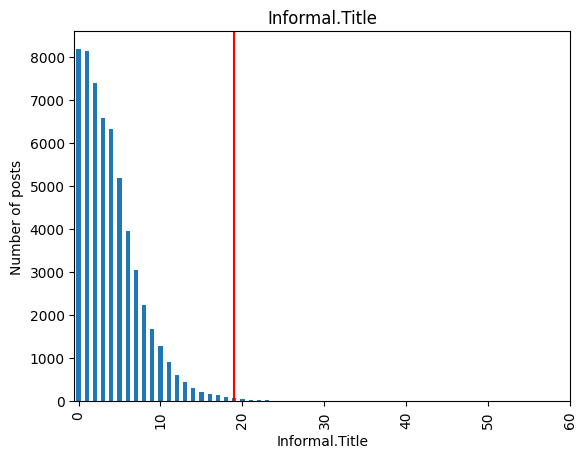

Reasoning 20.0 178


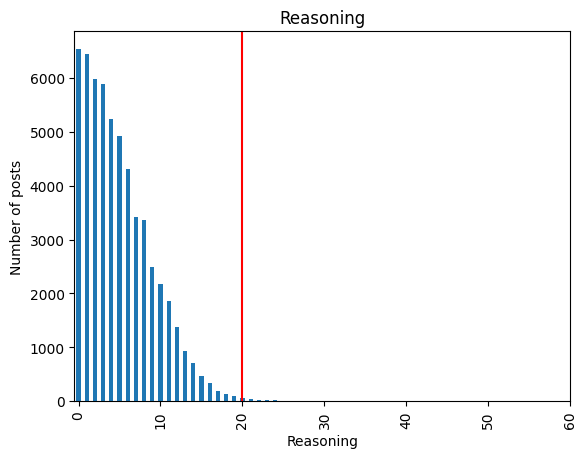

First.Person.Plural 40.0 188


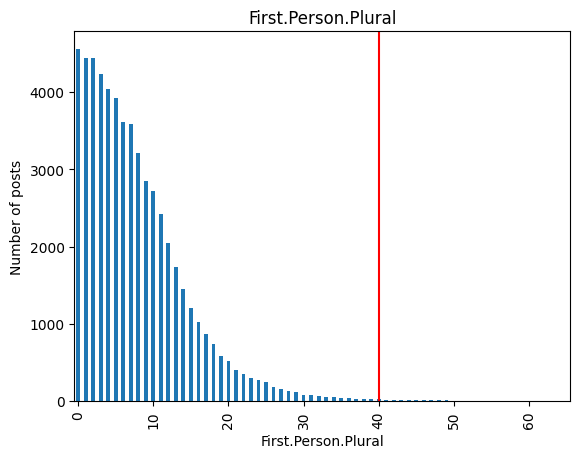

First.Person.Single 117.0 183


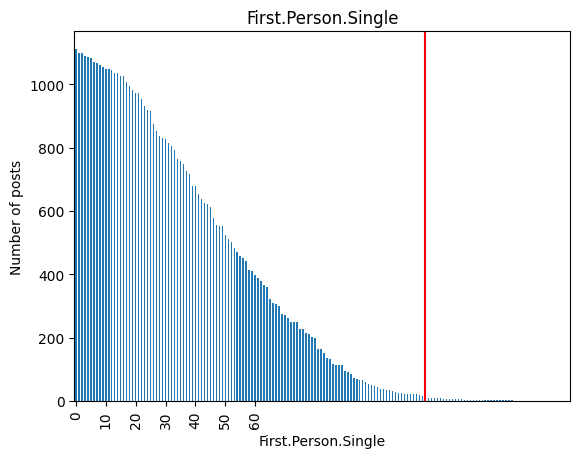

Second.Person 88.0 179


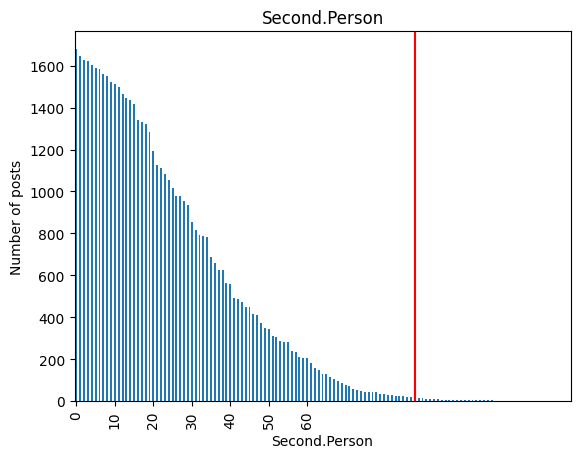

Questions 47.0 176


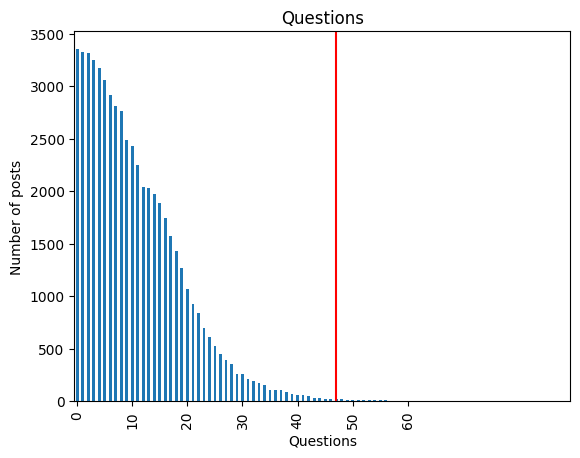

Apology 4.0 387


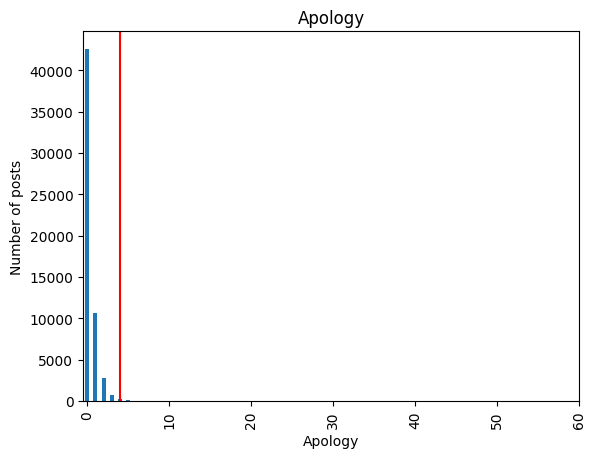

Truth.Intensifier 17.0 204


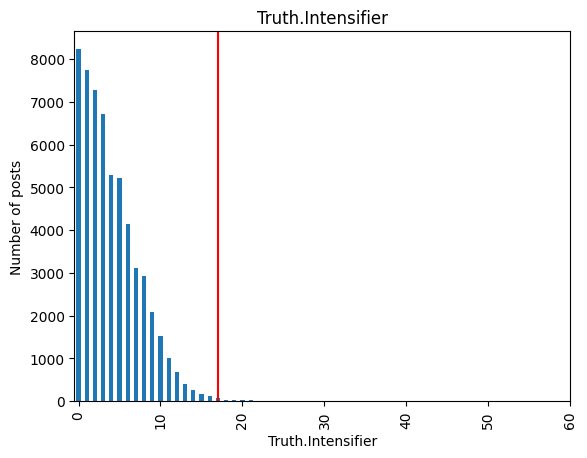

In [20]:
sigmas = dict()
for word in super_significant:
    threesigma = df_politics[word].quantile(0.997)
    extreme_count = len(df_politics[df_politics[word] >= threesigma])
    print(word, threesigma, extreme_count)
    plot = df_politics_cleaned.value_counts(word).plot(kind='bar', fontsize=10, xlabel = word, ylabel="Number of posts", title=word, xticks=np.arange(0, 61, 10));
    plt.axvline(x=threesigma, color='r', linestyle='-')
    plt.show()
    sigmas[word] = threesigma

df_politics_super_cleaned = df_politics.copy()
for word in sigmas:
    df_politics_super_cleaned = df_politics_super_cleaned[df_politics_super_cleaned[word] <= sigmas[word]]

<Axes: xlabel='political_leaning', ylabel='amount_of_cursewords'>

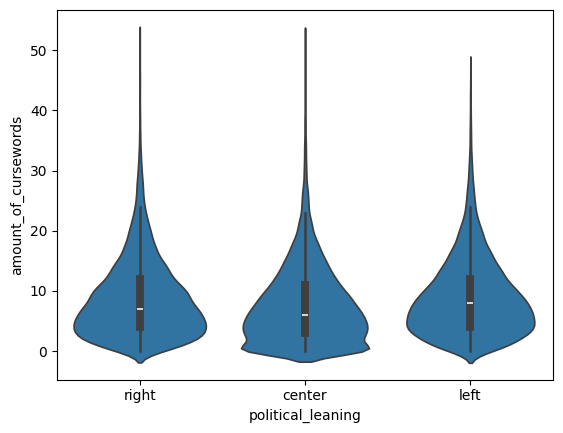

In [21]:
#create a violin plot with the political leaning on the x-axis and the amount of curse words on the y-axis
sns.violinplot(x="political_leaning", y="amount_of_cursewords", data=df_politics_super_cleaned)

### Look at the correlation with 3σ of the data

In [22]:
correlation = df_politics_super_cleaned['political_leaning_id'].corr(df_politics_super_cleaned['amount_of_cursewords'])
df_new = df_politics_super_cleaned[['political_leaning_id', 'amount_of_cursewords']].copy()
correlation_matrix = df_new.corr()
print(correlation_matrix)

                      political_leaning_id  amount_of_cursewords
political_leaning_id              1.000000             -0.010449
amount_of_cursewords             -0.010449              1.000000


In [23]:
# group by political leaning and create a lambda to fidn the mean of all the independent variables
df_politics_super_cleaned.drop(['Unnamed: 0', 'username', 'post', 'cleaned_post', 'political_leaning_id'], axis=1)[['political_leaning'] + super_significant].groupby('political_leaning').agg(lambda x: x.mean())

,amount_of_cursewords,Hedges,Impersonal.Pronoun,Swearing,Negation,Filler.Pause,Informal.Title,Reasoning,First.Person.Plural,First.Person.Single,Second.Person,Questions,Apology,Truth.Intensifier
political_leaning,,,,,,,,,,,,,,
center,7.677374,15.606293,86.695865,5.232847,34.116094,0.704802,3.689235,5.610864,7.468578,36.522239,27.662178,10.440614,0.323614,4.551149
left,9.042956,14.423701,91.439139,6.259667,36.656065,0.691659,4.022586,6.214709,8.189908,38.905296,28.469802,11.847831,0.363162,4.937531
right,8.757156,14.664178,87.713067,6.008533,37.058548,0.568652,4.350400,5.800593,8.517867,39.543881,30.012800,11.564326,0.327881,4.316859


In [24]:
X = df_politics_super_cleaned[super_significant]
Y = df_politics_super_cleaned['political_leaning_id']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# add constant
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# performing the regression and fitting the model
results = sm.OLS(y_train, X_train).fit()

print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     political_leaning_id   R-squared:                       0.024
Model:                              OLS   Adj. R-squared:                  0.023
Method:                   Least Squares   F-statistic:                     76.59
Date:                  Fri, 12 Jan 2024   Prob (F-statistic):          2.50e-217
Time:                          14:22:09   Log-Likelihood:                -49111.
No. Observations:                 44118   AIC:                         9.825e+04
Df Residuals:                     44103   BIC:                         9.838e+04
Df Model:                            14                                         
Covariance Type:              nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const       

Baseline prediction


------------------ Confusion Matrix -----------------



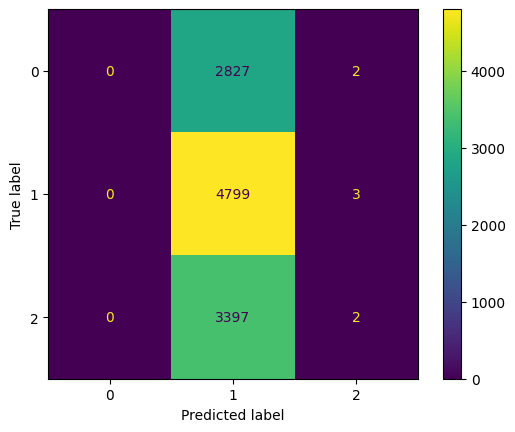


-------------------- Key Metrics --------------------

Accuracy: 0.44
Balanced Accuracy: 0.33

Micro Precision: 0.44
Micro Recall: 0.44
Micro F1-score: 0.44

Macro Precision: 0.24
Macro Recall: 0.33
Macro F1-score: 0.20

Weighted Precision: 0.28
Weighted Recall: 0.44
Weighted F1-score: 0.26


--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2829
           1       0.44      1.00      0.61      4802
           2       0.29      0.00      0.00      3399

    accuracy                           0.44     11030
   macro avg       0.24      0.33      0.20     11030
weighted avg       0.28      0.44      0.26     11030



C:\Users\20202007\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\20202007\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\20202007\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetric

In [25]:
y_pred = results.predict(X_test).round()

print('\n------------------ Confusion Matrix -----------------\n')
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred)).plot();
plt.show()
print('\n-------------------- Key Metrics --------------------')
print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))

# Random Forest Classifier

In [26]:
# Split the data into features (X) and target (Y)
X = df_politics_super_cleaned[super_significant]
Y = df_politics_super_cleaned['political_leaning_id']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1)

# --- Hyperparameter Tuning ---
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20),
              'max_features': randint(1,14)}

# for grid search
# forest_params = [{
#     'n_estimators': [50, 100, 200, 300, 400, 500],
#     'max_depth': [list(range(5, 15))], 
#     'max_features': list(range(6,14))
#     }]


# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=10, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

# --- end of hyperparameter tuning ---

# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred)).plot();
plt.show()
print('\n-------------------- Key Metrics --------------------')
print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.4945602901178604
F1 score: 0.4689740717428782


# Logistic


------------------ Confusion Matrix -----------------



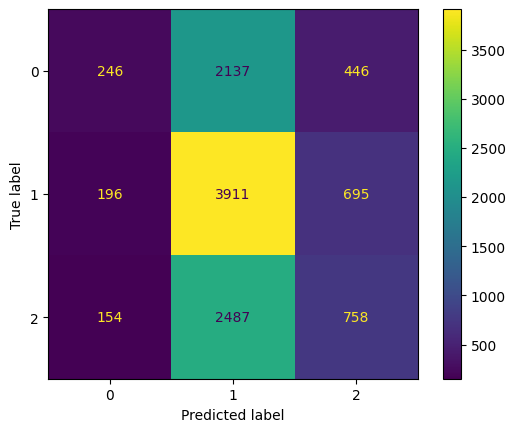


-------------------- Key Metrics --------------------

Accuracy: 0.45
Balanced Accuracy: 0.37

Micro Precision: 0.45
Micro Recall: 0.45
Micro F1-score: 0.45

Macro Precision: 0.42
Macro Recall: 0.37
Macro F1-score: 0.34

Weighted Precision: 0.43
Weighted Recall: 0.45
Weighted F1-score: 0.38


--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.41      0.09      0.14      2829
           1       0.46      0.81      0.59      4802
           2       0.40      0.22      0.29      3399

    accuracy                           0.45     11030
   macro avg       0.42      0.37      0.34     11030
weighted avg       0.43      0.45      0.38     11030



In [ ]:
# Split the data into features (X) and target (Y)
X = df_politics_super_cleaned[super_significant]
Y = df_politics_super_cleaned['political_leaning_id']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred)).plot();
plt.show()
print('\n-------------------- Key Metrics --------------------')
print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))

# Naive Bayes

Number of mislabeled points out of a total 11030 points : 6418

------------------ Confusion Matrix -----------------



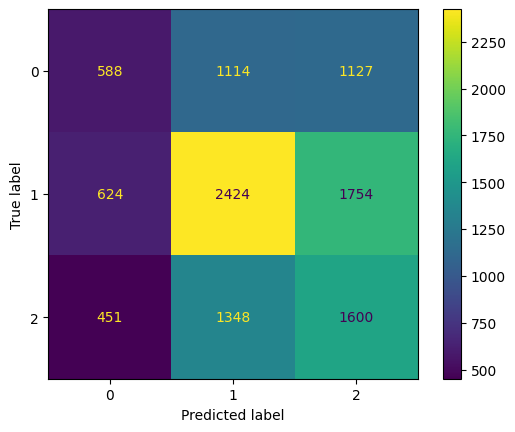


-------------------- Key Metrics --------------------

Accuracy: 0.42
Balanced Accuracy: 0.39

Micro Precision: 0.42
Micro Recall: 0.42
Micro F1-score: 0.42

Macro Precision: 0.40
Macro Recall: 0.39
Macro F1-score: 0.39

Weighted Precision: 0.42
Weighted Recall: 0.42
Weighted F1-score: 0.41


--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.35      0.21      0.26      2829
           1       0.50      0.50      0.50      4802
           2       0.36      0.47      0.41      3399

    accuracy                           0.42     11030
   macro avg       0.40      0.39      0.39     11030
weighted avg       0.42      0.42      0.41     11030



In [ ]:
# Split the data into features (X) and target (Y)
X = df_politics_super_cleaned[super_significant]
Y = df_politics_super_cleaned['political_leaning_id']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

gnb = GaussianNB()

y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

y_pred = gnb.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred)).plot();
plt.show()
print('\n-------------------- Key Metrics --------------------')
print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))

# Bare Decision Tree


------------------ Confusion Matrix -----------------



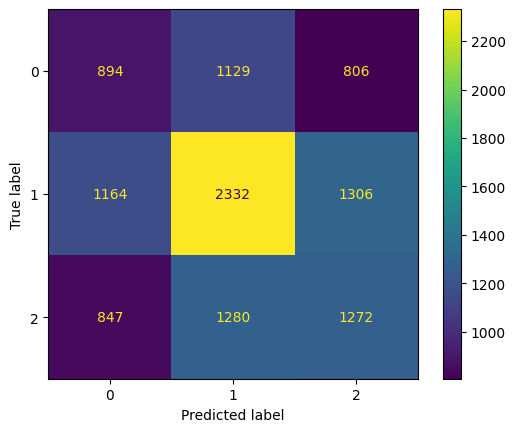


-------------------- Key Metrics --------------------

Accuracy: 0.41
Balanced Accuracy: 0.39

Micro Precision: 0.41
Micro Recall: 0.41
Micro F1-score: 0.41

Macro Precision: 0.39
Macro Recall: 0.39
Macro F1-score: 0.39

Weighted Precision: 0.41
Weighted Recall: 0.41
Weighted F1-score: 0.41


--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.31      0.32      0.31      2829
           1       0.49      0.49      0.49      4802
           2       0.38      0.37      0.38      3399

    accuracy                           0.41     11030
   macro avg       0.39      0.39      0.39     11030
weighted avg       0.41      0.41      0.41     11030



In [ ]:
# Split the data into features (X) and target (Y)
X = df_politics_super_cleaned[super_significant]
Y = df_politics_super_cleaned['political_leaning_id']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

clf = tree.DecisionTreeClassifier()

clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred)).plot();
plt.show()
print('\n-------------------- Key Metrics --------------------')
print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))

# XGBoost

based on https://www.kaggle.com/code/emmanuelfwerr/xgboost-multi-class-classification

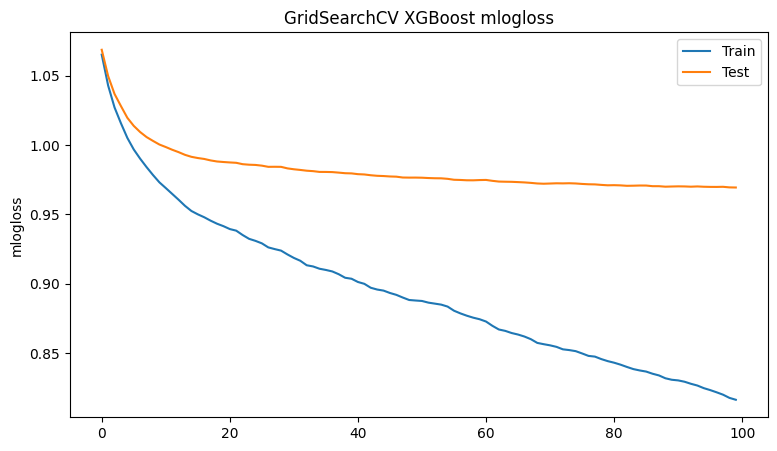

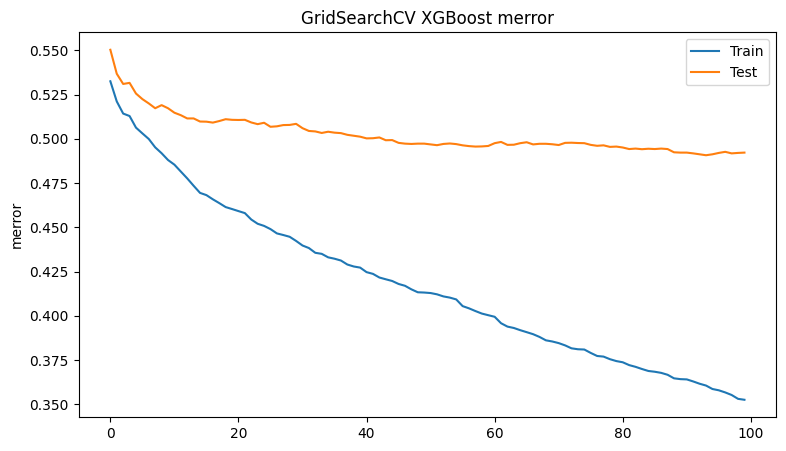


------------------ Confusion Matrix -----------------



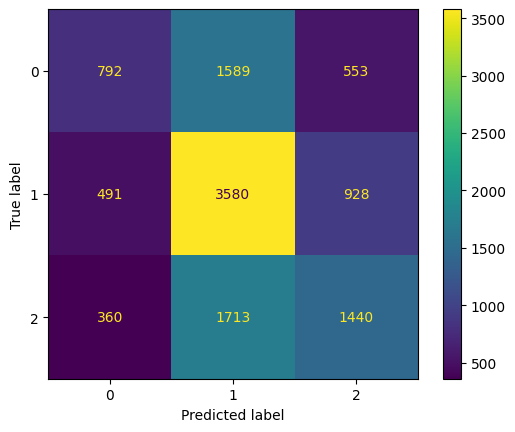


-------------------- Key Metrics --------------------

Accuracy: 0.51
Balanced Accuracy: 0.47

Micro Precision: 0.51
Micro Recall: 0.51
Micro F1-score: 0.51

Macro Precision: 0.50
Macro Recall: 0.47
Macro F1-score: 0.47

Weighted Precision: 0.50
Weighted Recall: 0.51
Weighted F1-score: 0.49


--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.48      0.27      0.35      2934
           1       0.52      0.72      0.60      4999
           2       0.49      0.41      0.45      3513

    accuracy                           0.51     11446
   macro avg       0.50      0.47      0.47     11446
weighted avg       0.50      0.51      0.49     11446

---------------------- XGBoost ----------------------


In [ ]:
# Split the data into features (X) and target (Y)
X = df_politics[super_significant]
Y = df_politics['political_leaning_id']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## ---------- XGBoost model v1 ----------
## base run of model with default hyperparameters

xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=3, 
                            early_stopping_rounds=10, 
                            eval_metric=['merror', 'auc', 'mlogloss'], 
                            seed=42)
xgb_clf.fit(X_train, 
            y_train,
            verbose=0, # set to 1 to see xgb training round intermediate results
            eval_set=[(X_train, y_train), (X_test, y_test)])

# preparing evaluation metric plots
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()

## ---------- Model Classification Report ----------
## get predictions and create model quality report

y_pred = xgb_clf.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred)).plot();
plt.show()
print('\n-------------------- Key Metrics --------------------')
print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))
print('---------------------- XGBoost ----------------------') # unnecessary fancy styling